In [1]:
# jupyter notebook
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

import matplotlib.pyplot as plt
import torchvision

In [2]:
# jupyter notebook
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [3]:
# jupyter notebook
class Args(argparse.Namespace):
    lr=0.0001
    lr_backbone=1e-05
    batch_size=2
    weight_decay=0.0001
    epochs=300
    lr_drop=200
    clip_max_norm=0.1
    frozen_weights=None
    backbone='resnet50'
    dilation=False
    position_embedding='sine'
    enc_layers=6
    dec_layers=6
    dim_feedforward=2048
    hidden_dim=256
    dropout=0.1
    nheads=8
    num_queries=100
    pre_norm=False
    masks=False
    aux_loss=True
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    dataset_file='coco'
    # coco_path=r'/mnt/c/MyData/2024/COCO/datasets'
    coco_path=r'C:\MyData\2024\COCO\datasets'
    coco_path = '/Users/jun-pyohong/Downloads/DeepLearningData/COCO/datasets'
    coco_panoptic_path=None
    remove_difficult=False
    output_dir=''
    device='mps'
    seed=42
    resume=''
    start_epoch=0
    eval=False
    num_workers=2
    world_size=1
    dist_url='env://'
    distributed=False

args = Args()

In [4]:
# jupyter notebook
# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
# jupyter notebook
dataset_train = build_dataset(image_set='train', args=args)

loading annotations into memory...
Done (t=7.19s)
creating index...
index created!


In [6]:
# jupyter notebook
print(len(dataset_train[0]))
print(dataset_train[0][0].shape)
print(dataset_train[1][0].shape)
dataset_train[0][1]

2
torch.Size([3, 512, 682])
torch.Size([3, 480, 646])


{'boxes': tensor([[0.5205, 0.6888, 0.9556, 0.5955],
         [0.2635, 0.2472, 0.4989, 0.4764],
         [0.3629, 0.7329, 0.4941, 0.5106],
         [0.6606, 0.4189, 0.6789, 0.7815],
         [0.3532, 0.1326, 0.1180, 0.0969],
         [0.2269, 0.1298, 0.0907, 0.0972],
         [0.3317, 0.2269, 0.1313, 0.1469],
         [0.3571, 0.0792, 0.1481, 0.1481]]),
 'labels': tensor([51, 51, 56, 51, 55, 55, 55, 55]),
 'image_id': tensor([9]),
 'area': tensor([282171.7812, 104435.5469, 116523.6641,  57095.6250,   5263.0371,
           3898.9131,   8482.9902,   6992.8281]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([736, 981])}

In [7]:
dataset_train[0][1]

{'boxes': tensor([[0.5000, 0.6808, 1.0000, 0.6346],
         [0.7779, 0.2320, 0.4442, 0.4640],
         [0.7073, 0.7278, 0.5855, 0.5441],
         [0.4174, 0.4048, 0.8347, 0.8096],
         [0.7881, 0.0880, 0.1717, 0.1033],
         [0.9529, 0.0850, 0.0941, 0.1036],
         [0.8193, 0.1885, 0.1910, 0.1565],
         [0.7823, 0.0550, 0.2154, 0.1100]]),
 'labels': tensor([51, 51, 56, 51, 55, 55, 55, 55]),
 'image_id': tensor([9]),
 'area': tensor([351720.2812, 114242.3984, 176553.1562, 374516.9375,   9830.8096,
           5405.9229,  16567.4375,  13133.4287]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([753, 736])}

In [8]:
example = dataset_train[0]
example

(tensor([[[ 0.1254,  0.1597,  0.1768,  ..., -2.1008, -2.1008, -2.0837],
          [ 0.1254,  0.1768,  0.1939,  ..., -2.0837, -2.0665, -2.0494],
          [ 0.1254,  0.1768,  0.2111,  ..., -2.1008, -2.0837, -2.0665],
          ...,
          [-2.0152, -2.0323, -2.0152,  ..., -2.0152, -2.0323, -2.0494],
          [-2.0665, -2.0494, -1.9980,  ..., -2.0152, -2.0323, -2.0323],
          [-2.0837, -2.0837, -2.0837,  ..., -2.0152, -2.0323, -2.0494]],
 
         [[ 0.9055,  0.9405,  0.9580,  ..., -1.6331, -1.6331, -1.6155],
          [ 0.9055,  0.9580,  0.9755,  ..., -1.6331, -1.6155, -1.5980],
          [ 0.9055,  0.9580,  0.9930,  ..., -1.6506, -1.6506, -1.6331],
          ...,
          [-1.9832, -1.9482, -1.9132,  ..., -2.0182, -2.0357, -2.0357],
          [-1.9832, -1.9832, -1.9657,  ..., -2.0182, -2.0357, -2.0357],
          [-1.9482, -1.9657, -1.9832,  ..., -2.0182, -2.0357, -2.0357]],
 
         [[ 1.5942,  1.6117,  1.6291,  ...,  0.0953,  0.0953,  0.0953],
          [ 1.5768,  1.6291,

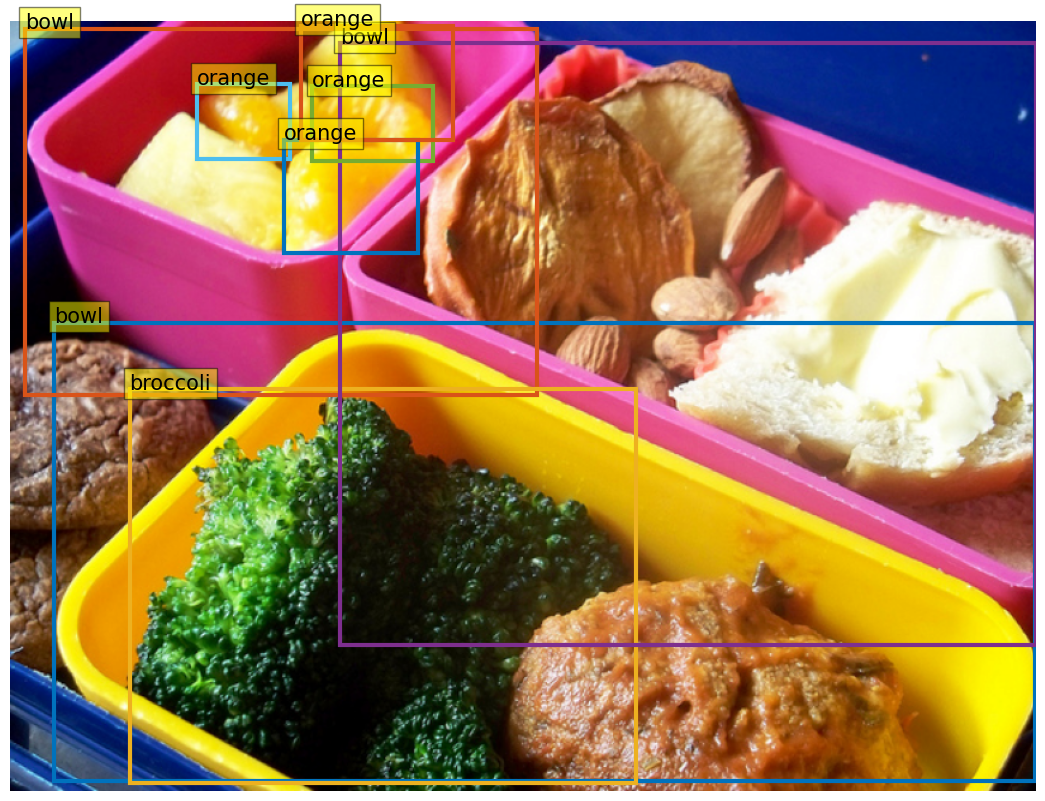

In [9]:
plot_results(example[0], example[1]['labels'], example[1]['boxes'])

In [10]:
device = 'mps'
model, criterion, postprocessors = build_model(args)
model.to(device)
model

/Users/jun-pyohong/opt/anaconda3/envs/torch220/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jun-pyohong/opt/anaconda3/envs/torch220/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, BatchSampler
sampler = RandomSampler(dataset_train)
batch_sampler = BatchSampler(sampler, args.batch_size, drop_last=True)
data_loader = DataLoader(dataset_train, batch_sampler=batch_sampler, collate_fn=utils.collate_fn, num_workers=args.num_workers)

for X, y in data_loader:
    break


In [12]:
type(X)

util.misc.NestedTensor

In [14]:
preds = model(X.to(device))
print(preds.keys())


KeyboardInterrupt



In [16]:
preds['pred_logits'].shape, preds['pred_boxes'].shape

(torch.Size([2, 100, 92]), torch.Size([2, 100, 4]))

In [17]:
import torch.nn as nn


emb = nn.Embedding(100, 256)
emb(torch.tensor([1,2,3,4,5]))

tensor([[-1.0877,  0.9057,  0.0574,  ...,  0.9195,  0.5996,  0.3138],
        [ 0.1019, -0.0316,  1.8342,  ..., -0.2075, -0.1382, -0.8834],
        [-1.0491,  0.4952, -0.0055,  ..., -0.8927, -1.4497, -0.2861],
        [-0.4845, -0.2517,  0.2711,  ..., -0.8908,  0.4418, -0.1477],
        [-1.1470, -1.5058,  1.5589,  ..., -0.9153, -0.2533, -1.3310]],
       grad_fn=<EmbeddingBackward0>)

In [18]:
emb(torch.tensor([1,2,3,4,5])).shape

torch.Size([5, 256])

In [23]:
check = emb(torch.tensor([1]).repeat(2))
torch.all(check[0] == check[1])

tensor(True)

In [29]:
multi_head = nn.MultiheadAttention(768, 12)

total_parameters = 0
for n, p in multi_head.named_parameters():
    total_parameters += p.numel()
    print(n, p.numel())

# print total number of parameters with b, m, k format
print(f"Total parameters: {total_parameters:,}")

in_proj_weight 1769472
in_proj_bias 2304
out_proj.weight 589824
out_proj.bias 768
Total parameters: 2,362,368


In [17]:
import torchvision

m = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

new_m = torchvision.models._utils.IntermediateLayerGetter(m, {'layer1': 'feat1', 'layer2': 'feat2'})
new_m

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/jun-pyohong/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.2MB/s]


IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU

In [15]:
import torch
out = new_m(torch.rand(1, 3, 224, 224))
type(out)

NameError: name 'new_m' is not defined

In [19]:
out.keys()

odict_keys(['feat1', 'feat2'])

In [20]:
import torch
N =4
S = 15

key_padding_mask = torch.arange(S)[None, :] >= torch.tensor([5,7,9,12])[:, None]

key_padding_mask

tensor([[False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True]])

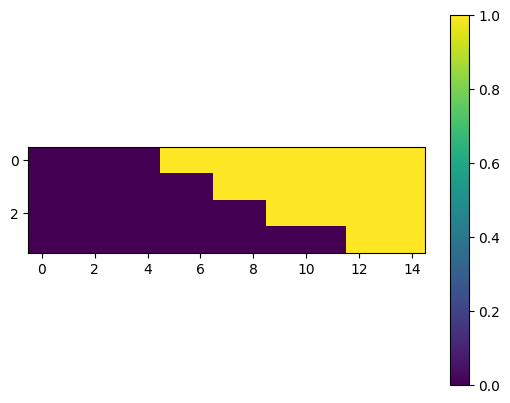

In [21]:
import matplotlib.pyplot as plt

vis = key_padding_mask.cpu().numpy()
plt.imshow(vis)
plt.colorbar()
plt.show()

In [22]:
key_padding_mask=torch.masked_fill(torch.zeros(N,S), key_padding_mask, float('-inf'))

key_padding_mask

tensor([[0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf]])

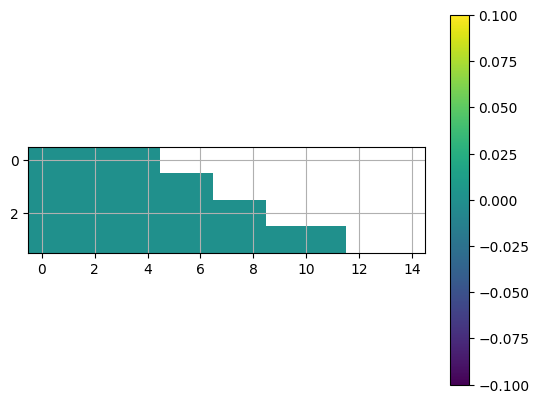

In [23]:
vis_mask = key_padding_mask.cpu().numpy()
# plot with grid and number
plt.imshow(vis_mask)
plt.colorbar()
# plot gird wit
plt.grid(True)
plt.show()

In [26]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show


model_ckpt = 'bert-base-uncased'
tokenzier = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)

text = 'time files like an arrow'
show(model, 'bert', tokenzier, text, display_mode='light', layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
inputs = tokenzier(text, return_tensors='pt', add_special_tokens=False)
inputs.input_ids

tensor([[2051, 6764, 2066, 2019, 8612]])

In [31]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

In [32]:
inputs_embed = token_emb(inputs.input_ids)
inputs_embed.shape

torch.Size([1, 5, 768])

In [33]:
import torch
from math import sqrt

query = key = inputs_embed
dim_k = key.size(-1)

768

score 계산

$ \text{query} \in \mathbb{R}^ {5 \times 768} , \text{key} \in \mathbb{R}^ {5 \times 768}$,

$$ \text{query} \times \text{key}^\text{T} \in \mathbb{R}^ {5 \times 5} $$


In [35]:
scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
scores.shape

torch.Size([1, 5, 5])

In [36]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.shape

torch.Size([1, 5, 5])

In [39]:
weights[0].cpu().detach().numpy()

array([[1.0000000e+00, 3.0390449e-12, 5.4109061e-13, 1.0213911e-12,
        1.6501670e-13],
       [5.4397871e-13, 1.0000000e+00, 4.7819984e-13, 3.2339282e-13,
        2.8948355e-13],
       [2.7984326e-13, 1.3816863e-12, 1.0000000e+00, 3.0620377e-13,
        1.2527002e-12],
       [1.7340545e-12, 3.0673001e-12, 1.0051627e-12, 1.0000000e+00,
        2.3645500e-12],
       [3.7743151e-14, 3.6990428e-13, 5.5400357e-13, 3.1855765e-13,
        1.0000000e+00]], dtype=float32)

In [61]:

multi_head_attention = nn.MultiheadAttention(embed_dim=768, num_heads=8)

query = key = value = inputs_embed

key_mask = torch.arange(inputs_embed.shape[-1])[None, None, :].repeat(1, 5, 1) >= torch.tensor([768//2])
print(key_mask.shape)



# import torch.nn.functional as F
# 
# F._canonical_mask

torch.Size([1, 5, 768])


In [60]:
key_mask[0]

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [63]:
torch.arange(inputs_embed.shape[-1])[None, None, :].repeat(1, 5, 1).shape

torch.Size([1, 5, 768])

In [65]:
output, weights = multi_head_attention(query, key, value, key_padding_mask=key_mask)

AssertionError: For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D but found 3-D tensor instead